In [1]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
import sys
import os 
workdir = "/Users/mihaylov/research/qa-knowreader-long-docs"
sys.path.append("/Users/mihaylov/research/qa-knowreader-long-docs")
sys.path.append("/Users/mihaylov/research/qa-knowreader-long-docs/docqa")

os.chdir(workdir)

In [3]:
from docqa.commands.evaluate_qanet_semantic_flat import *
from docqa.data import *

Deprecated cache directory found (/Users/mihaylov/.allennlp/datasets).  Please remove this directory from your system to free up space.


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


/Users/mihaylov/anaconda3/envs/docqa/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:55: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mihaylov/anaconda3/envs/docqa/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/mihaylov/anaconda3/envs/docqa/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/mihaylov/anaconda3/envs/docqa/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mihaylov/anaconda3/envs/docqa/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/

In [4]:
args_ns = create_argparse_namespace(archive_file = workdir + "/_trained_models/qanet_semantic_flat_concat_sdp_debug/model.tar.gz",
                              evaluation_data_file = "/Users/mihaylov/research/document-parsing-pipeline/tests/fixtures/data/narrativeqa/third_party/wikipedia/summaries-all.csv.parsed.jsonl.srl.jsonl.with_q_spans.jsonl.with_exp.with_sdp.json.train.2",
                              output_file = "predictions_dev_jup.json",
                              item_ids = "00936497f5884881f1df23f4834f6739552cee8b##016[15:30];00936497f5884881f1df23f4834f6739552cee8b##005[17:45];0029bdbe75423337b551e42bb31f9a102785376f##023",
                              cuda_device = -1,
                              batch_size = 1,
                              output_attention = "True",
                              file_open_mode = "w",
                              overrides = "",
                              display_attention_matplot = "True",
                              )

# Display attentions


In [5]:
def draw(data, x, y, ax, x2=None, y1=None):
    seaborn.heatmap(data, 
                    xticklabels=x,
                    yticklabels=y, 
                    vmin=0.0, vmax=1.0, 
                    square=True, 
                    cbar=False, ax=ax)

    
def format_token(tkn_id, tkn, best_span, gold_span):
    prefix = ""
    suffix = ""
    if tkn_id == best_span[0]:
        prefix += "[" 
    if tkn_id == gold_span[0]:
        prefix += "{" 
    if tkn_id == gold_span[1]:
        suffix += "}" 
    if tkn_id == best_span[1]:
        suffix += "]" 
        
    return prefix + tkn + suffix
        
    
def display_attentions(tokens, meta, output, output_metadata, feat_id_to_feat_name, crop_range):
    modeling_layer_output = output_metadata["modeling_layer"]
    modeling_layer_iters = sorted(list(modeling_layer_output.keys()))
    
    #selected_span = output["best_span"].data[0].tolist()
    #gold_span = meta["token_spans"][0]
    #tokens = [format_token(tkn_id, tkn, selected_span, gold_span) for tkn_id, tkn in enumerate(metadata["passage_tokens"])]
    if crop_range is not None:
        print(crop_range)
        tokens = tokens[crop_range[0]: crop_range[1]]
        
    print(tokens)
    
    
    axs_head_iter = None
    for iter_key_id, iter_key in enumerate(modeling_layer_iters):
        iter_value = modeling_layer_output[iter_key]
        print("-" + iter_key)
        
        for encoder_block_key in sorted(iter_value.keys()):
            print("--" + encoder_block_key)
            
            encoder_block_value = iter_value[encoder_block_key]
                                  
            attention_value = encoder_block_value["attention"]
            if isinstance(attention_value, list):
                attention_value = np.array(attention_value)
            
            semantic_views_q_value = encoder_block_value.get("semantic_views_q", None)
            if semantic_views_q_value is not None and not isinstance(semantic_views_q_value, list):
                semantic_views_q_value = semantic_views_q_value.tolist()
            
            semantic_views_sent_mask_value = encoder_block_value.get("semantic_views_sent_mask", None)
            if semantic_views_sent_mask_value is not None and not isinstance(semantic_views_sent_mask_value, list):
                semantic_views_sent_mask_value = semantic_views_sent_mask_value.tolist()
        
            num_heads = attention_value.shape[0]
            if axs_head_iter is None:
                fig, axs_head_iter = plt.subplots(num_heads, len(modeling_layer_iters), figsize=(30, 80))
                
            for head_id in range(num_heads):
                head_attention = attention_value[head_id]
                semantic_views_q_curr = None
                if semantic_views_q_curr is not None:
                    semantic_views_q_curr = semantic_views_q_value[head_id]
                # normalize in [0,1.0]
                head_attention = head_attention/head_attention.max()
                               
                if crop_range is not None:
                    head_attention = head_attention[crop_range[0]:crop_range[1], crop_range[0]:crop_range[1]]
                
                    if semantic_views_q_curr is not None :
                        semantic_views_q_curr[crop_range[0]:crop_range[1]]
                
                feats = []
                if semantic_views_q_curr is not None:
                    feats = [feat_id_to_feat_name.get(int(x), "") for x in semantic_views_q_value]
                    
                axs = axs_head_iter[head_id][iter_key_id]
                axs.set_title("head {0}, iter {1}".format(head_id, iter_key_id))
                #fig, axs = plt.subplots(1, figsize=(10, 10))
                draw(head_attention, tokens, tokens if iter_key_id == 0 else feats, ax=axs)
                
    plt.show()
    
    

# Persist data - remove the break at the end!

In [6]:
import numpy as np

def replace_json_lists_with_shapes(json_item):
    new_json = {}
    for key, value in json_item.items():
        if isinstance(value, list):
            new_json[key] = str(np.array(value).shape)
        elif isinstance(value, dict):
            new_json[key] = replace_json_lists_with_shapes(value)
        elif isinstance(value, list):
            new_json[key] = str(value.shape)
        
    return new_json



In [7]:

# function for working with output of the model
def _persist_data_matplot(file_handle, 
                  metadata, 
                  model_output, 
                  id2label=None,
                  id_to_meta=None,
                  feat_id_to_feat_name=None,
                  display_attention_matplot=True) -> None:
    if metadata:
        batch_size = len(metadata)
        for index, meta in enumerate(metadata):
            res = {}
            item_id = meta.get("id", "n/a")
            res["id"] = item_id
            res["meta"] = meta
            # We persist model output which matches batch_size in length and is not a Variable
            for key, value in model_output.items():
                if key == "output_metadata":
                    crop_range = None
                    if id_to_meta is not None:
                        id_meta_curr = id_to_meta.get(item_id, None)
                        if id_meta_curr is not None:
                            crop_range = id_meta_curr["attention_range"]
        
                    sequence_len = model_output["span_start_logits"].shape[-1]
                    attentions_metadata = attentions_to_json(value, index, batch_size, sequence_len , crop_range)
                    attentions_shapes = replace_json_lists_with_shapes(attentions_metadata)
                    print(json.dumps(attentions_shapes, indent=4))
                    
                    print("Passage:")
                    print(meta["passage_tokens"])
                    print("Question:")
                    print(meta["question_tokens"])
                    print("Gold answer:")
                    gold_span = meta["token_spans"][0]
                    print(meta["passage_tokens"][gold_span[0]:gold_span[1]+1])
                    
                    print("Selected answer:")
                    print(meta["token_spans"][0])
                    
                    display_attentions(meta["passage_tokens"], meta, model_output, attentions_metadata, feat_id_to_feat_name, crop_range)
                    # res["attentions_metadata"] = attentions_metadata
                    #print(attentions_metadata)

                curr_value = value
                if isinstance(value, torch.autograd.Variable) or isinstance(value, Tensor):
                    curr_value = value.data.tolist()

                if not isinstance(curr_value, torch.autograd.Variable) \
                        and isinstance(curr_value, list) \
                        and len(curr_value) == batch_size:
                    val = curr_value[index]
                    res[key] = val

            if "label_probs" in res and id2label is not None:
                labels_by_probs = sorted([[id2label[li], lp] for li, lp in enumerate(res["label_probs"])], key=lambda x:x[1], reverse=True)
                res["labels_by_prob"] = labels_by_probs
                res["label_predicted"] = labels_by_probs[0][0]

            file_handle.write(json.dumps(res))
            file_handle.write("\n")
            



In [8]:
# Evaluate evaluate_matplot
def evaluate_matplot(model: Model,
             instances: Iterable[Instance],
             data_iterator: DataIterator,
             output_file: str = None,
             file_mode="w",
             id_to_meta: Dict[str, Any] = {},
             feat_id_to_feat_name: Dict[int, str]= {},
             display_attention_matplot = False,
             ) -> Dict[str, Any]:
    model.eval()

    iterator = data_iterator(instances, num_epochs=1, shuffle=False)
    logger.info("Iterating over dataset")
    generator_tqdm = Tqdm.tqdm(iterator, total=data_iterator.get_num_batches(instances))
    with ExitStack() as stack:
        if output_file is None:
            file_handle = None
        else:
            file_handle = stack.enter_context(open(output_file, file_mode))

        for batch in generator_tqdm:
            model_output = model(**batch)
            metrics = model.get_metrics()
            if file_handle:
                id2label = model.vocab.get_index_to_token_vocabulary("labels")
                _persist_data_matplot(file_handle, batch.get("metadata"), model_output,
                              id2label=id2label,
                              id_to_meta=id_to_meta,
                              feat_id_to_feat_name=feat_id_to_feat_name,
                              display_attention_matplot=display_attention_matplot)
            description = ', '.join(["%s: %.2f" % (name, value) for name, value in metrics.items()]) + " ||"
            generator_tqdm.set_description(description)

    return model.get_metrics()

56it [00:00, 1247.30it/s]
  0%|          | 0/3 [00:00<?, ?it/s]

{
    "encoded_passage": {
        "encoder_block_001": {
            "attention": "(16, 50, 50)",
            "semantic_views_q": "(16, 50)",
            "semantic_views_sent_mask": "(16, 50)",
            "mask": "(50,)"
        }
    },
    "encoded_question": {
        "encoder_block_001": {
            "attention": "(16, 19, 19)",
            "semantic_views_q": "(16, 19)",
            "semantic_views_sent_mask": "(16, 19)",
            "mask": "(19,)"
        }
    },
    "modeling_layer": {
        "modeling_layer_iter_000": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
                "mask": "(50,)"
            }
        },
        "modeling_layer_iter_001": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
    

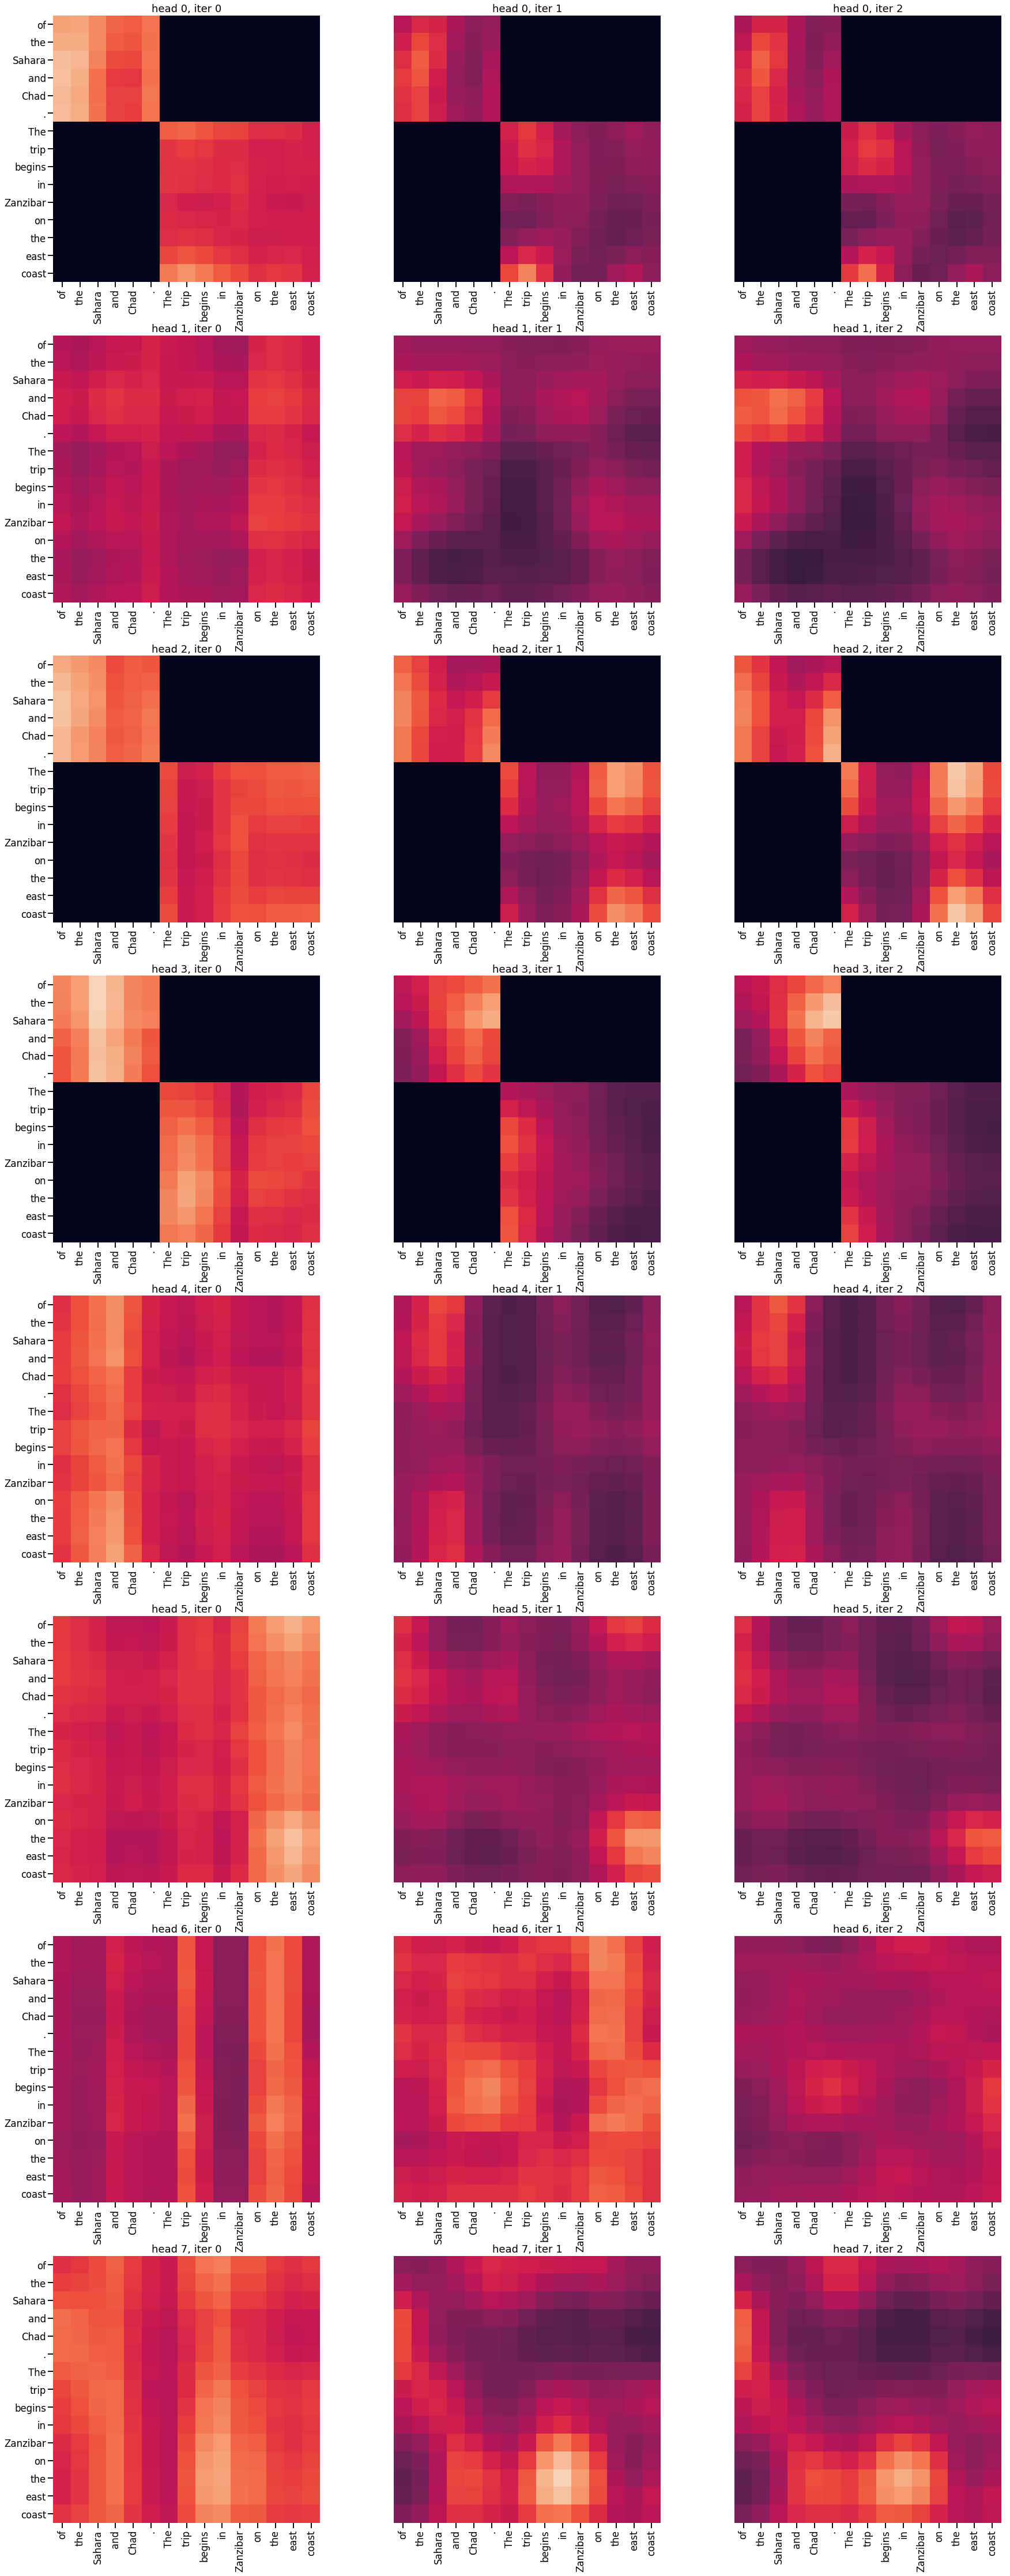

start_acc: 0.00, end_acc: 0.00, span_acc: 0.00, em: 0.00, f1: 0.00, rouge-1: 0.00, rouge-2: 0.00, rouge-3: 0.00, rouge-4: 0.00, rouge-l: 0.00, rouge-w: 0.00 ||:  33%|███▎      | 1/3 [00:21<00:43, 21.78s/it]

{
    "encoded_passage": {
        "encoder_block_001": {
            "attention": "(16, 50, 50)",
            "semantic_views_q": "(16, 50)",
            "semantic_views_sent_mask": "(16, 50)",
            "mask": "(50,)"
        }
    },
    "encoded_question": {
        "encoder_block_001": {
            "attention": "(16, 11, 11)",
            "semantic_views_q": "(16, 11)",
            "semantic_views_sent_mask": "(16, 11)",
            "mask": "(11,)"
        }
    },
    "modeling_layer": {
        "modeling_layer_iter_000": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
                "mask": "(50,)"
            }
        },
        "modeling_layer_iter_001": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
    

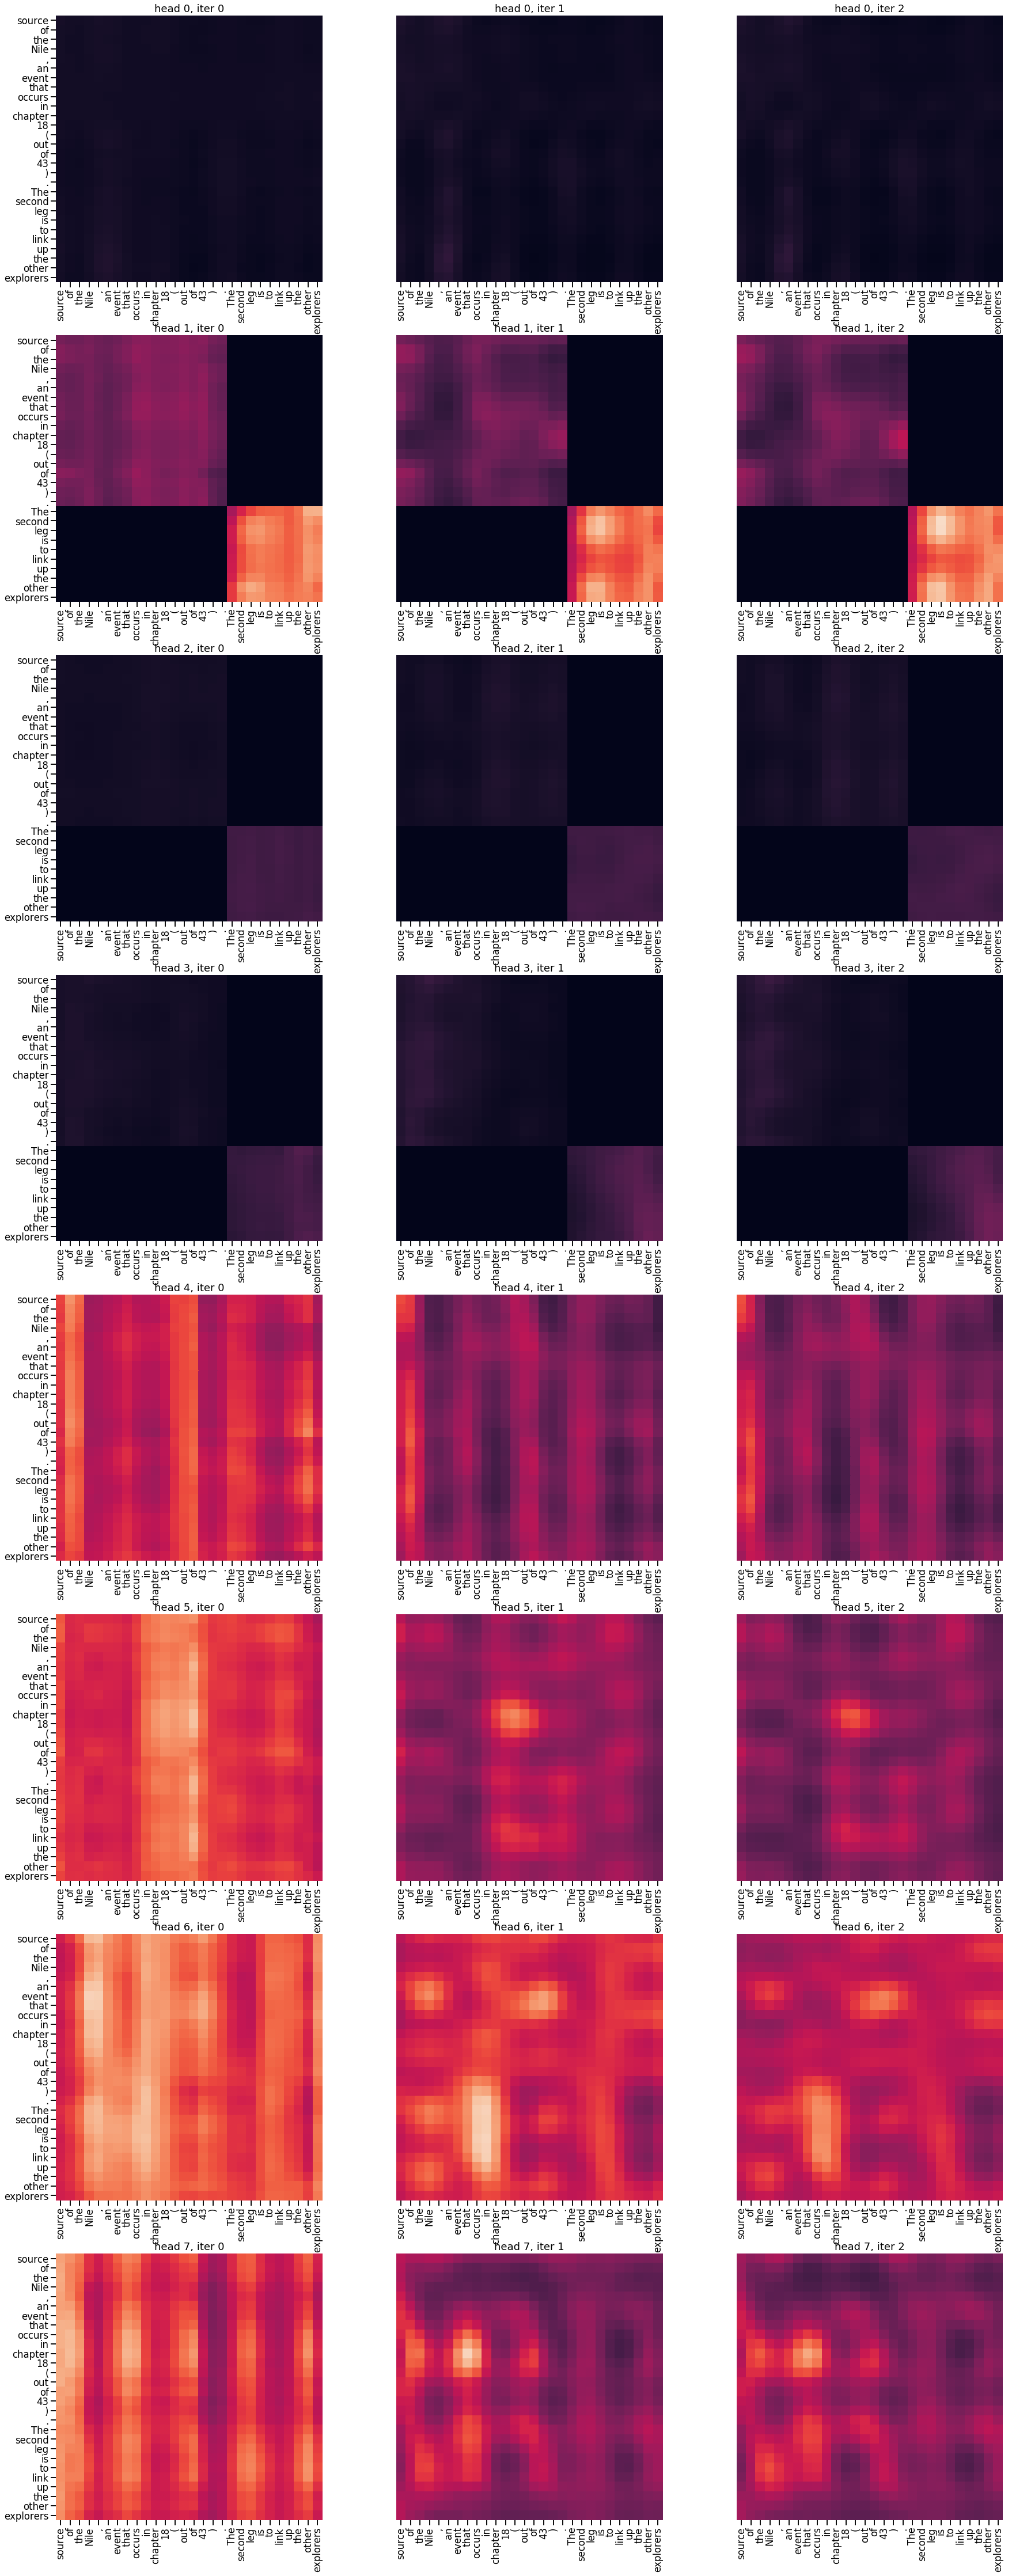

start_acc: 0.00, end_acc: 0.00, span_acc: 0.00, em: 0.00, f1: 0.08, rouge-1: 0.12, rouge-2: 0.07, rouge-3: 0.00, rouge-4: 0.00, rouge-l: 0.15, rouge-w: 0.11 ||:  67%|██████▋   | 2/3 [00:58<00:26, 26.32s/it]

{
    "encoded_passage": {
        "encoder_block_001": {
            "attention": "(16, 50, 50)",
            "semantic_views_q": "(16, 50)",
            "semantic_views_sent_mask": "(16, 50)",
            "mask": "(50,)"
        }
    },
    "encoded_question": {
        "encoder_block_001": {
            "attention": "(16, 5, 5)",
            "semantic_views_q": "(16, 5)",
            "semantic_views_sent_mask": "(16, 5)",
            "mask": "(5,)"
        }
    },
    "modeling_layer": {
        "modeling_layer_iter_000": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
                "mask": "(50,)"
            }
        },
        "modeling_layer_iter_001": {
            "encoder_block_001": {
                "attention": "(8, 50, 50)",
                "semantic_views_q": "(8, 50)",
                "semantic_views_sent_mask": "(8, 50)",
         

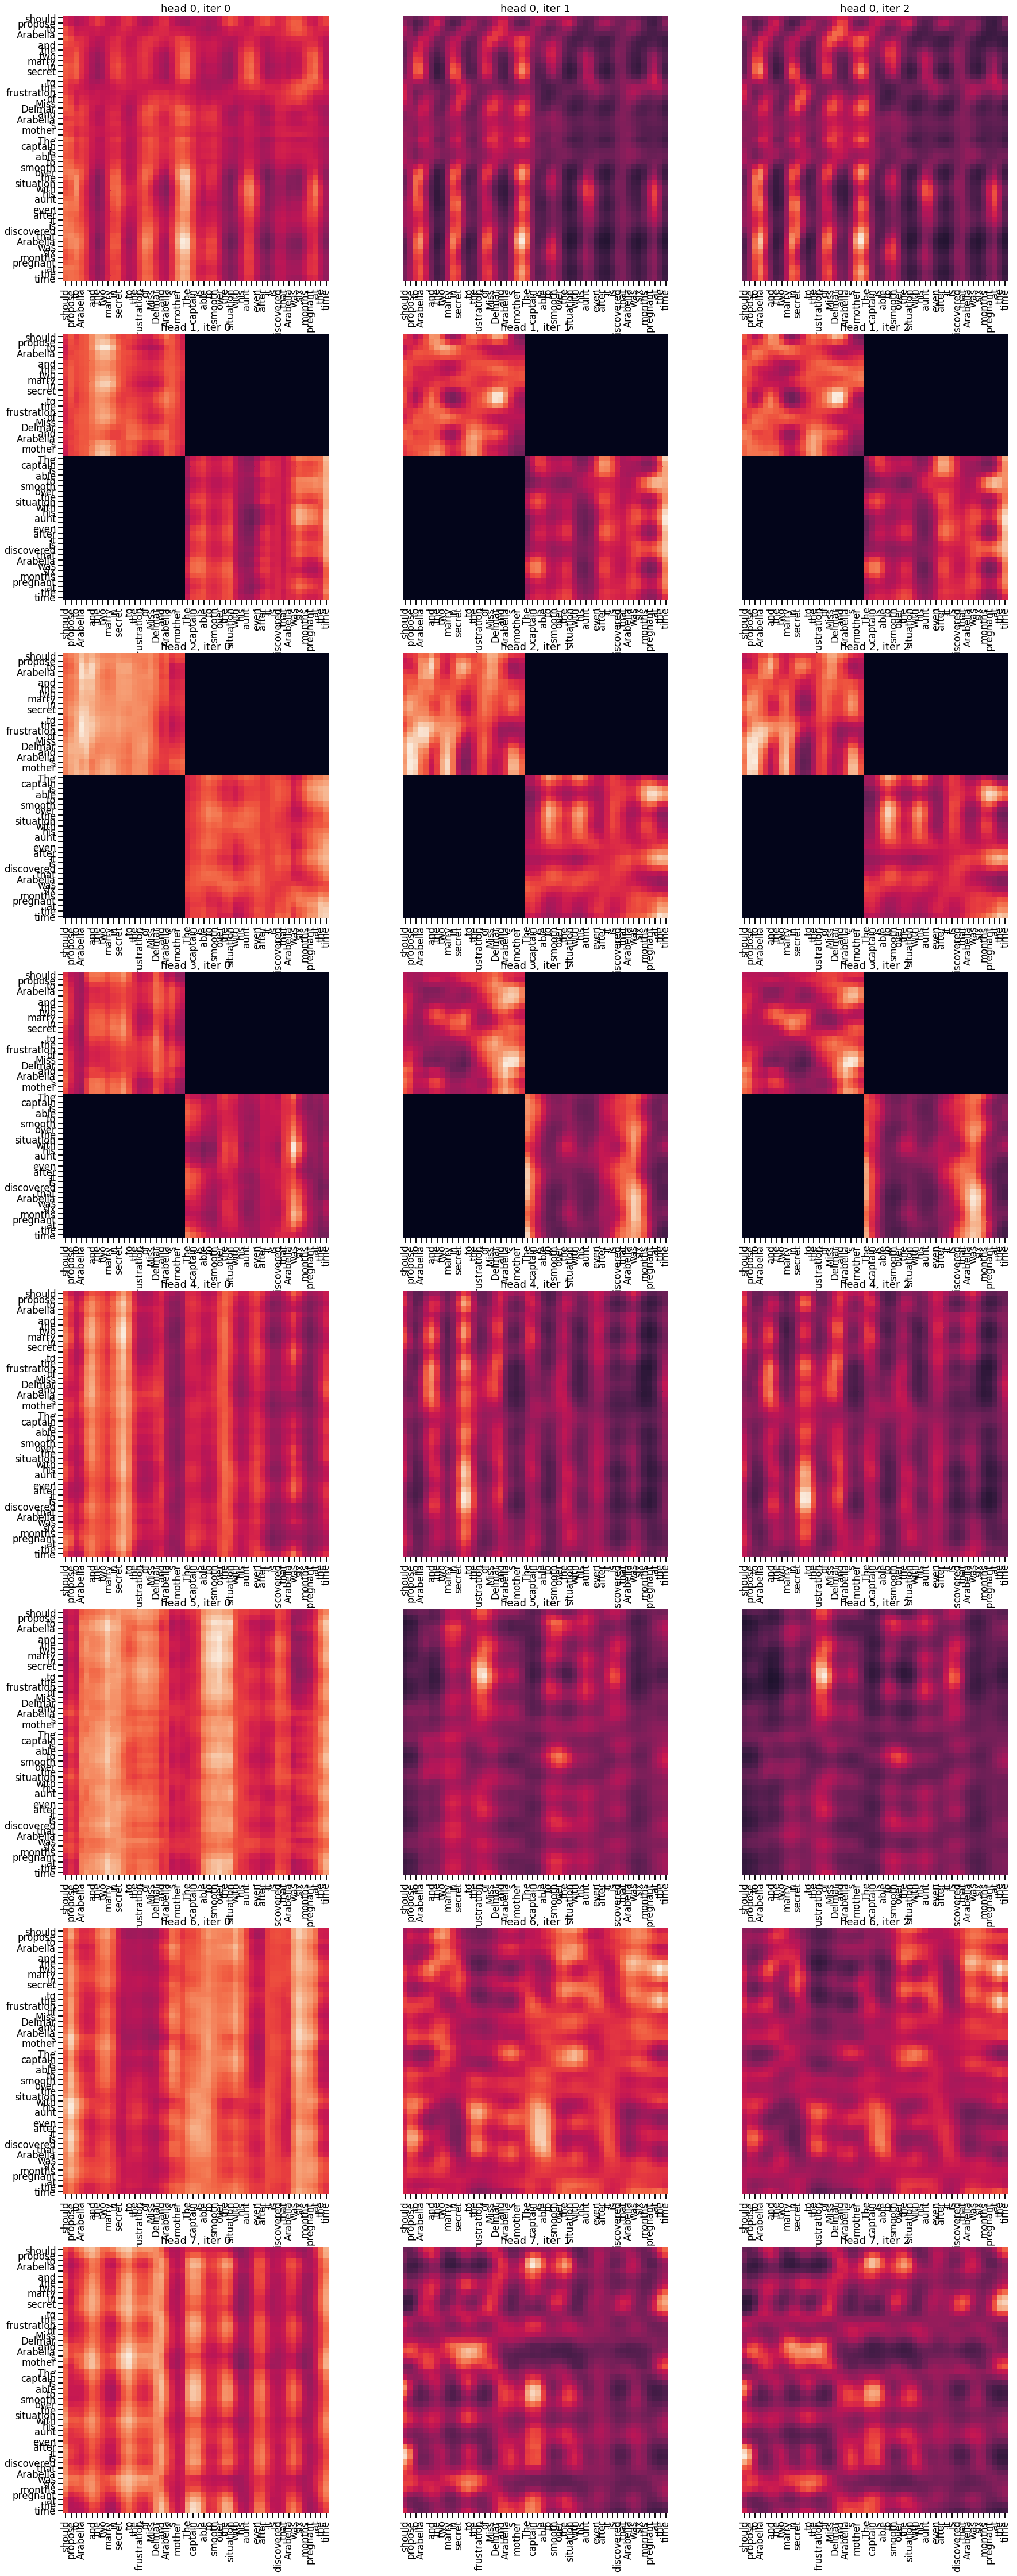

start_acc: 0.00, end_acc: 0.00, span_acc: 0.00, em: 0.00, f1: 0.13, rouge-1: 0.18, rouge-2: 0.12, rouge-3: 0.04, rouge-4: 0.00, rouge-l: 0.23, rouge-w: 0.17 ||: 100%|██████████| 3/3 [01:57<00:00, 35.93s/it]


In [9]:
metrics = evaluate_from_args(args_ns, func_eval=evaluate_matplot)


In [10]:

print("Results:")
print(json.dumps(metrics, indent=4))


Results:
{
    "start_acc": 0.0,
    "end_acc": 0.0,
    "span_acc": 0.0,
    "em": 0.0,
    "f1": 0.12535612535612536,
    "rouge-1": 0.1784313725490196,
    "rouge-2": 0.11851851851851854,
    "rouge-3": 0.041666666666666664,
    "rouge-4": 0.0,
    "rouge-l": 0.2276606242975884,
    "rouge-w": 0.16650144745745823
}
